In [2]:
import math
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from collections import defaultdict
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.decomposition import PCA
import seaborn as sns

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('PyTorch/GPU')
else:
    device = torch.device('cpu')
    print('PyTorch/CPU')

PyTorch/CPU


In [4]:
config = {
    'batch_size': 32,
    'learning_rate': 0.0002,
    'epochs': 10,
    'latent_size': 100,
    'data_size': 371,
    'model_dir': './'
}

In [5]:
features_df = pd.read_csv('preprocessed_features.csv')
target_df = pd.read_csv('Encoded_target.csv')
print(features_df.shape)

(1280, 371)


In [6]:
class DatasetDEAP(Dataset):
    
    def __init__(self, features_df, target_df, transform=None):
        assert len(features_df) == len(target_df)
        self.features = torch.FloatTensor(features_df.values)
        self.target = torch.FloatTensor(target_df.values)
        self.transform = transform
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        features_ = self.features[index]
        if self.transform is not None:
            features_ = self.transform(features_)
        return features_, self.target[index]
    

data = DatasetDEAP(features_df, target_df["Arousal"])
data_loader = DataLoader(data, batch_size=config['batch_size'], shuffle=True)

In [7]:
batches = enumerate(data_loader)
batch_idx, (features_batch, target_batch) = next(batches)
print(features_batch.data.shape)
print(torch.min(features_batch.data), torch.max(features_batch.data))

torch.Size([32, 371])
tensor(0.) tensor(1.)


In [8]:
class Generator(nn.Module):
    
    def __init__(self, input_size=config['latent_size'], output_size=config['data_size'], hidden_size=128):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
                                 nn.Linear(input_size, hidden_size),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Linear(hidden_size, hidden_size*2),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Linear(hidden_size*2, output_size),
                                 nn.Sigmoid()
                                )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self, input_size=config['data_size'], hidden_size=128):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
                                 nn.Linear(input_size, hidden_size*2),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Linear(hidden_size*2, hidden_size),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Linear(hidden_size, 1),
                                 nn.Sigmoid()
                                )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [10]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=config['learning_rate'])
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['learning_rate'])

criterion = torch.nn.BCELoss()

In [11]:
def train_gran(generator=generator, discriminator=discriminator, real_train_loader=data_loader,
               batch_size=config['batch_size'], latent_size=config['latent_size'], num_epochs=10,
               save_models=True, plot_losses=True, device='cpu'):
    
    generator.to(device)
    discriminator.to(device)
    
    history = defaultdict(list)
    
    # loop over epochs
    for epoch in range(num_epochs):
        
        d_loss = 0.
        g_loss = 0.

        # loop over batches in each epochs
        for (features, _) in real_train_loader:
            
            features = features.view(batch_size, -1).to(device)
            
            # train discriminator
            # --------------------------
            discriminator.train()
            generator.eval()
            
            preds = discriminator(features)
            real_loss = criterion(preds, torch.ones_like(preds).to(device))
            
            fake_features = generator(torch.randn(batch_size, latent_size).to(device))
            fake_preds = discriminator(fake_features)
            fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds).to(device))
            
            discriminator_loss = real_loss + fake_loss
            discriminator.zero_grad(); generator.zero_grad()
            discriminator_loss.backward()
            discriminator_optimizer.step()
            
            # train generator
            # --------------------------
            generator.train()
            discriminator.eval()
            
            forged_feafures = generator(torch.randn(batch_size, latent_size).to(device))
            forged_preds = discriminator(forged_feafures)
            forged_loss = criterion(forged_preds, torch.ones_like(forged_preds).to(device))
            
            generator.zero_grad();
            forged_loss.backward()
            generator_optimizer.step()
            
            # losses
            d_loss += discriminator_loss
            g_loss += forged_loss
            
        # statistics
        d_loss /= len(real_train_loader)
        g_loss /= len(real_train_loader)   
        print("epoch: {}/{}, d_loss:{:.5f}, g_loss:{:.5f}".format(epoch+1, num_epochs, d_loss, g_loss))
        history['g_losses'].append(g_loss.data.item())
        history['d_losses'].append(d_loss.data.item())
        
    # Save the model checkpoints 
    if save_models:
        torch.save(generator.state_dict(), 'model-gen.ckpt')
        torch.save(discriminator.state_dict(), 'model-discr.ckpt')
    
    # plot losses
    if plot_losses:
        plt.plot(history['g_losses'], label='generator')
        plt.plot(history['d_losses'], label='discriminator')
        plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
    
    return history

epoch: 1/300, d_loss:0.77518, g_loss:1.56953
epoch: 2/300, d_loss:0.36976, g_loss:2.84359
epoch: 3/300, d_loss:1.00178, g_loss:1.64416
epoch: 4/300, d_loss:1.13657, g_loss:1.14629
epoch: 5/300, d_loss:1.03811, g_loss:1.23644
epoch: 6/300, d_loss:0.47764, g_loss:2.12565
epoch: 7/300, d_loss:0.34688, g_loss:2.53078
epoch: 8/300, d_loss:0.59279, g_loss:2.35536
epoch: 9/300, d_loss:1.21045, g_loss:2.31947
epoch: 10/300, d_loss:0.55908, g_loss:2.41113
epoch: 11/300, d_loss:0.21951, g_loss:3.25606
epoch: 12/300, d_loss:0.15708, g_loss:3.82903
epoch: 13/300, d_loss:0.13679, g_loss:4.07053
epoch: 14/300, d_loss:0.16950, g_loss:3.83504
epoch: 15/300, d_loss:0.29911, g_loss:3.17204
epoch: 16/300, d_loss:0.55601, g_loss:2.22062
epoch: 17/300, d_loss:0.34660, g_loss:2.56382
epoch: 18/300, d_loss:0.13085, g_loss:3.15118
epoch: 19/300, d_loss:0.41827, g_loss:2.39371
epoch: 20/300, d_loss:0.32549, g_loss:2.74059
epoch: 21/300, d_loss:0.25768, g_loss:3.00253
epoch: 22/300, d_loss:0.30625, g_loss:2.693

epoch: 178/300, d_loss:0.87938, g_loss:1.86078
epoch: 179/300, d_loss:0.85003, g_loss:1.66655
epoch: 180/300, d_loss:0.82760, g_loss:1.83859
epoch: 181/300, d_loss:0.71063, g_loss:2.37664
epoch: 182/300, d_loss:0.97798, g_loss:2.16918
epoch: 183/300, d_loss:0.86414, g_loss:2.31896
epoch: 184/300, d_loss:0.90578, g_loss:2.20748
epoch: 185/300, d_loss:0.51650, g_loss:2.60247
epoch: 186/300, d_loss:0.72293, g_loss:2.03871
epoch: 187/300, d_loss:0.82333, g_loss:1.80257
epoch: 188/300, d_loss:0.83637, g_loss:1.61975
epoch: 189/300, d_loss:0.67161, g_loss:1.84402
epoch: 190/300, d_loss:0.57496, g_loss:1.91460
epoch: 191/300, d_loss:0.86091, g_loss:1.70400
epoch: 192/300, d_loss:1.12217, g_loss:1.36052
epoch: 193/300, d_loss:0.99766, g_loss:1.45266
epoch: 194/300, d_loss:0.73103, g_loss:1.89470
epoch: 195/300, d_loss:1.09180, g_loss:1.52010
epoch: 196/300, d_loss:1.11595, g_loss:1.42472
epoch: 197/300, d_loss:1.09455, g_loss:1.51905
epoch: 198/300, d_loss:0.85457, g_loss:1.69401
epoch: 199/30

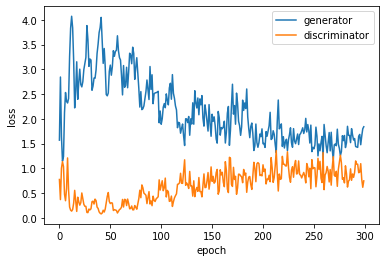

In [12]:
history = train_gran(num_epochs=300, device=device)

In [23]:
def generate_gan_data(generator=generator, n_samples=1, latent_size=config['latent_size'], device='cpu'):
    gan_data = generator(torch.randn(n_samples, latent_size).to(device))
    return np.array(gan_data.data)

GAN shape: (1000, 371)


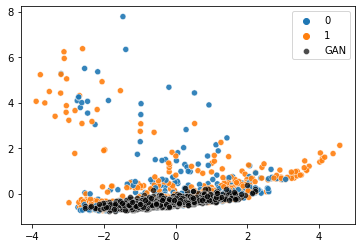

In [34]:
# real data
pca = PCA(n_components=2)
pca.fit(features_df.values)
features_pca = pca.transform(features_df.values)
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=target_df['Arousal'], alpha=0.9)

# GAN data
gan_features = generate_gan_data(n_samples=1000)
print("GAN shape:", gan_features.shape)
gan_features_pca = pca.transform(gan_features)
sns.scatterplot(x=gan_features_pca[:, 0], y=gan_features_pca[:, 1], color='k', alpha=0.7, label='GAN');

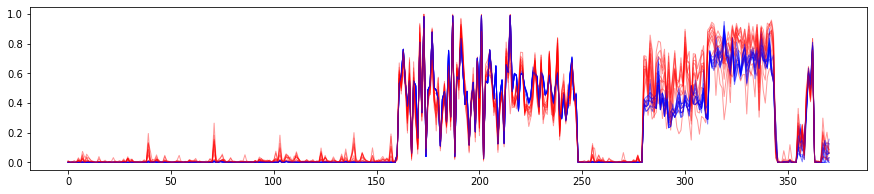

In [35]:
fig, ax = plt.subplots(figsize=(15,3))
for i in range(10):
    plt.plot(features_df.values[i, :], color='b', lw=1, alpha=0.5)
    plt.plot(gan_features[i, :], color='red', lw=1, alpha=0.4)

In [36]:
gan_features_df = pd.DataFrame(gan_features, columns=features_df.columns)
gan_features_df.to_csv("gan_features.csv", index=False)